# Tidy Modeling with R

In [2]:
library(modeldata)

data(ames)

# What are the dimensions of this df
dim(ames)

[1] 2930   74

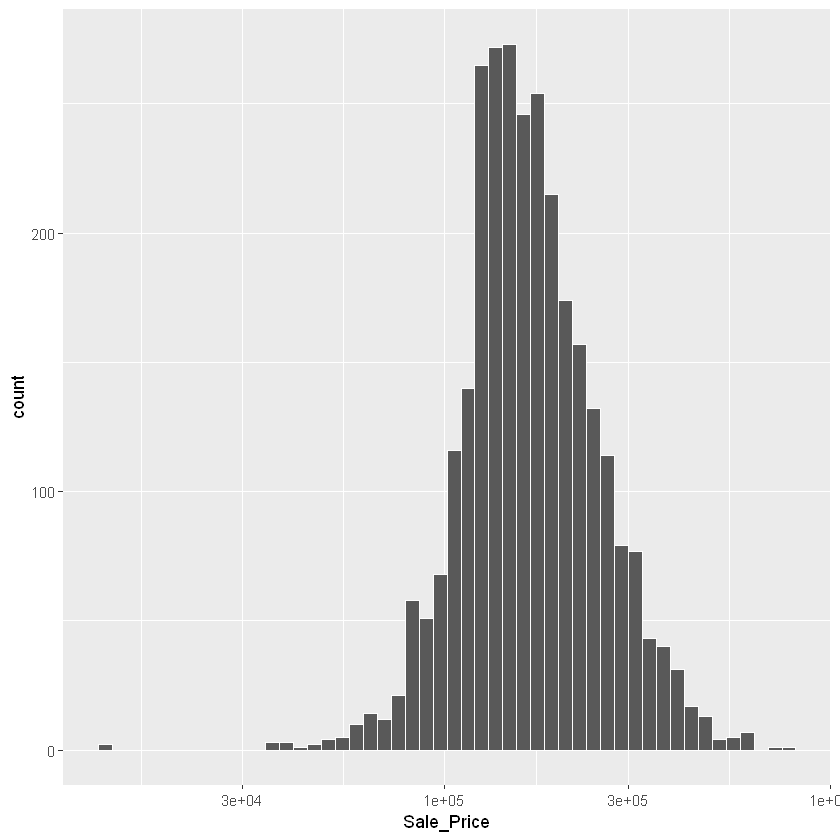

In [5]:
library(tidymodels)

tidymodels_prefer()


ggplot(
        ames,
        aes(x = Sale_Price)
      ) +
    geom_histogram(bins=50, col="white") + 
    # Visualization shows a right skew so lets use the log to scale this
    scale_x_log10()

In [ ]:
# Choose to prelog all the y values
# ames <- ames |>
#             mutate(Sales_Price = log10(Sales_Price))

## Spliting Data

In [6]:
set.seed(123)


# Creating the r_split object
ames_split <- initial_split(ames, prop = 0.8, strata = Sale_Price)

ames_train <- training(ames_split)

ames_test <- testing(ames_split)

In [ ]:
# # If Validation set is wanted:
# set.seed(52)
# # To put 60% into training, 20% in validation, and 20% in testing:
# ames_val_split <- initial_validation_split(ames, prop = c(0.6, 0.2))

# ames_train <- training(ames_val_split)
# ames_test <- testing(ames_val_split)
# ames_val <- validation(ames_val_split)

# Model Fitting

For tidymodels, the approach to specifying a model is intended to be more unified:

Specify the type of model based on its mathematical structure (e.g., linear regression, random forest, KNN, etc).

Specify the engine for fitting the model. Most often this reflects the software package that should be used, like Stan or glmnet. These are models in their own right, and parsnip provides consistent interfaces by using these as engines for modeling.

When required, declare the mode of the model. The mode reflects the type of prediction outcome. For numeric outcomes, the mode is regression; for qualitative outcomes, it is classification.14 If a model algorithm can only address one type of prediction outcome, such as linear regression, the mode is already set.

In [ ]:
# Instantiate the regression model
lm_model <- 
    linear_reg() |>
    # Specify the engine used for regression
    set_engine("lm") |> # This could be set_engine("glmnet") | set_engine("stan")
    # Use the translate function to provide details on how the library converts the user's code to the package syntax
    translate()


# linear_reg(penalty = 1) 
#     |> set_engine("glmnet") 
#     |> translate()


# linear_reg() 
#     |> set_engine("stan") 
#     |> translate()

In [9]:
# Instantiate the regression model
lm_model <- 
    linear_reg() |>
    # Specify the engine used for regression
    set_engine("lm") |> 
    # Use the translate function to provide details on how the library converts the user's code to the package syntax
    translate()


# Fitting the formula
lm_form_fit <-
    # Specify the model
    lm_model |>
    # Specify the formula using the training data
    fit(Sale_Price ~ Longitude + Latitude, data = ames_train)


lm_form_fit

parsnip model object


Call:
stats::lm(formula = Sale_Price ~ Longitude + Latitude, data = data)

Coefficients:
(Intercept)    Longitude     Latitude  
 -124970600      -774125      1252758  


In [12]:
# Using Random Forest arguments with parsnip
rf_model <-   rand_forest(trees = 1000, min_n = 5) |>
                    set_engine("ranger") |>
                    set_mode("regression") |>
                    translate()


rf_form_fit <-
                # Specify the fr model
                rf_model |>
                # Specify the formula
                fit(Sale_Price ~ Longitude + Latitude, data = ames_train)


rf_form_fit

parsnip model object

Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, num.trees = ~1000,      min.node.size = min_rows(~5, x), num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1)) 

Type:                             Regression 
Number of trees:                  1000 
Sample size:                      2342 
Number of independent variables:  2 
Mtry:                             1 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        variance 
OOB prediction error (MSE):       1669670360 
R squared (OOB):                  0.7272088 

## Using the model results

In [22]:
model_res <- lm_form_fit |>
                extract_fit_engine() |>
                summary()

model_res


Call:
stats::lm(formula = Sale_Price ~ Longitude + Latitude, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-142269  -46064  -18811   32771  530253 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -124970601    6535572  -19.12   <2e-16 ***
Longitude      -774125      58123  -13.32   <2e-16 ***
Latitude       1252758      81424   15.39   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 72330 on 2339 degrees of freedom
Multiple R-squared:  0.1459,	Adjusted R-squared:  0.1452 
F-statistic: 199.8 on 2 and 2339 DF,  p-value: < 2.2e-16


In [24]:
# Get the model parameters
coef(model_res)

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-124970600.5,6535572.05,-19.12160,7.592333e-76
Longitude,-774125.2,58123.27,-13.31868,4.597016e-39
Latitude,1252758.2,81423.62,15.38568,5.873653e-51


In [20]:
rf_form_fit |>
    extract_fit_engine() 

                          Length Class         Mode     
predictions               2342   -none-        numeric  
num.trees                    1   -none-        numeric  
num.independent.variables    1   -none-        numeric  
mtry                         1   -none-        numeric  
min.node.size                1   -none-        numeric  
prediction.error             1   -none-        numeric  
forest                       7   ranger.forest list     
splitrule                    1   -none-        character
treetype                     1   -none-        character
r.squared                    1   -none-        numeric  
call                         8   -none-        call     
importance.mode              1   -none-        character
num.samples                  1   -none-        numeric  
replace                      1   -none-        logical  

In [25]:
# Preview model parameters
tidy(lm_form_fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-124970600.5,6535572.05,-19.12160,7.592333e-76
Longitude,-774125.2,58123.27,-13.31868,4.597016e-39
Latitude,1252758.2,81423.62,15.38568,5.873653e-51


## Making Predictions

In [26]:
ames_test |>
    slice(1:5)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,70,10500,Pave,No_Alley_Access,Regular,Lvl,AllPub,FR2,⋯,No_Fence,None,0,4,2010,ConLI,Normal,115000,-93.62277,42.05638
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,83,10159,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,4,2010,New,Partial,395192,-93.65373,42.06113


In [27]:
ames_test_small <- ames_test |>
                    slice(1:5)


ames_test_small |>
    select(Sale_Price) |>
    # Add th predictions 
    bind_cols(predict(lm_form_fit, ames_test_small)) |>
    # Add the 95% prediction intervals
    bind_cols(predict(lm_form_fit, ames_test_small, type = "pred_int" ))

Sale_Price,.pred,.pred_lower,.pred_upper
<int>,<dbl>,<dbl>,<dbl>
105000,185072.5,43143.37,327001.6
172000,184342.4,42413.60,326271.1
189900,209795.9,67857.25,351734.6
115000,191615.5,49680.16,333550.8
395192,221546.2,79599.91,363492.4


# Model Workflows

> It is important to focus on the broader modeling process, instead of only fitting the specific model used to estimate parameters. This broader process includes any preprocessing steps, the model fit itself, as well as potential post-processing activities. In this book, we will refer to this more comprehensive concept as the model workflow and highlight how to handle all its components to produce a final model equation.

> In other software, such as Python or Spark, similar collections of steps are called pipelines. In tidymodels, the term “pipeline” already connotes a sequence of operations chained together with a pipe operator (such as %>% from magrittr or the newer native |>). Rather than using ambiguous terminology in this context, we call the sequence of computational operations related to modeling workflows.

In [34]:
lm_model <- 
            linear_reg() |> 
            set_engine("lm")


lm_wflow <- 
        # Add a workflow object
        workflow() |>
        add_model(lm_model) |>
        add_variables(outcome=Sale_Price, predictors = c(Longitude, Latitude))


lm_wflow

══ Workflow ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Variables
Model: linear_reg()

── Preprocessor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Outcomes: Sale_Price
Predictors: c(Longitude, Latitude)

── Model ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Linear Regression Model Specification (regression)

Computational engine: lm 


# Feature Engineering

Feature engineering entails reformatting predictor values to make them easier for a model to use effectively. This includes transformations and encodings of the data to best represent their important characteristics. Imagine that you have two predictors in a data set that can be more effectively represented in your model as a ratio; creating a new predictor from the ratio of the original two is a simple example of feature engineering.

Take the location of a house in Ames as a more involved example. There are a variety of ways that this spatial information can be exposed to a model, including neighborhood (a qualitative measure), longitude/latitude, distance to the nearest school or Iowa State University, and so on. When choosing how to encode these data in modeling, we might choose an option we believe is most associated with the outcome. The original format of the data, for example numeric (e.g., distance) versus categorical (e.g., neighborhood), is also a driving factor in feature engineering choices.

Other examples of preprocessing to build better features for modeling include:

- Correlation between predictors can be reduced via feature extraction or the removal of some predictors.

- When some predictors have missing values, they can be imputed using a sub-model.

- Models that use variance-type measures may benefit from coercing the distribution of some skewed predictors to be symmetric by estimating a transformation.

Feature engineering and data preprocessing can also involve reformatting that may be required by the model. Some models use geometric distance metrics and, consequently, numeric predictors should be centered and scaled so that they are all in the same units. Otherwise, the distance values would be biased by the scale of each column.

Suppose that an initial ordinary linear regression model were fit to these data. Recalling that, in Chapter 4, the sale prices were pre-logged, a standard call to lm() might look like:

```{R}
lm(Sale_Price ~ Neighborhood + log10(Gr_Liv_Area) + Year_Built + Bldg_Type, data = ames)
```


When this function is executed, the data are converted from a data frame to a numeric design matrix (also called a model matrix) and then the least squares method is used to estimate parameters. In Section 3.2 we listed the multiple purposes of the R model formula; let’s focus only on the data manipulation aspects for now. What this formula does can be decomposed into a series of steps:

- Sale price is defined as the outcome while neighborhood, gross living area, the year built, and building type variables are all defined as predictors.

- A log transformation is applied to the gross living area predictor.

- The neighborhood and building type columns are converted from a non-numeric format to a numeric format (since least squares requires numeric predictors).



> A recipe is also an object that defines a series of steps for data processing. Unlike the formula method inside a modeling function, the recipe defines the steps via `step_*()` functions without immediately executing them; it is only a specification of what should be done. Here is a recipe equivalent to the previous formula that builds on the code summary above

In [35]:
simple_ames <-
    recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type, 
          data = ames_train) |>
    step_log(Gr_Liv_Area, base = 10) |>
    step_dummy(all_nominal_predictors())


simple_ames



── Recipe ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Operations 

• Log transformation on: Gr_Liv_Area

• Dummy variables from: all_nominal_predictors()



Let’s break this down:

- The call to recipe() with a formula tells the recipe the roles of the “ingredients” or variables (e.g., predictor, outcome). It only uses the data ames_train to determine the data types for the columns.

- step_log() declares that Gr_Liv_Area should be log transformed.

- step_dummy() specifies which variables should be converted from a qualitative format to a quantitative format, in this case, using dummy or indicator variables. An indicator or dummy variable is a binary numeric variable (a column of ones and zeroes) that encodes qualitative information; we will dig deeper into these kinds of variables in Section 8.4.1.

The function all_nominal_predictors() captures the names of any predictor columns that are currently factor or character (i.e., nominal) in nature. This is a dplyr-like selector function similar to starts_with() or matches() but that can only be used inside of a recipe.

> Other selectors specific to the recipes package are: all_numeric_predictors(), all_numeric(), all_predictors(), and all_outcomes(). As with dplyr, one or more unquoted expressions, separated by commas, can be used to select which columns are affected by each step.

What is the advantage to using a recipe, over a formula or raw predictors? There are a few, including:

- These computations can be recycled across models since they are not tightly coupled to the modeling function.
- A recipe enables a broader set of data processing choices than formulas can offer.
- The syntax can be very compact. For example, all_nominal_predictors() can be used to capture many variables for specific types of processing while a formula would require each to be explicitly listed.
- All data processing can be captured in a single R object instead of in scripts that are repeated, or even spread across different files.

In [37]:
# Addomg tp workflow


lm_wflow <-
    lm_wflow |>
    # Remove the existing variables
    remove_variables() |>
    # Add the recipe
    add_recipe(simple_ames)

lm_wflow

══ Workflow ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_log()
• step_dummy()

── Model ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Linear Regression Model Specification (regression)

Computational engine: lm 


In [39]:
# Fit the workflow to the training data
lm_fit <- fit(lm_wflow, ames_train)


# Predict with the test data
predict(
        lm_fit, 
        ames_test |>
        slice(1:3)
       )

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


.pred_res
<dbl>
113505.0
153679.2
190172.6


In [40]:
# Extracting the bare model
lm_fit |>
    extract_recipe(estimated = TRUE)



── Recipe ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Training information 

Training data contained 2342 data points and no incomplete rows.



── Operations 

• Log transformation on: Gr_Liv_Area | Trained

• Dummy variables from: Neighborhood, Bldg_Type | Trained



In [41]:
# To tidy the model fit: 
lm_fit |> 
  # This returns the parsnip object:
  extract_fit_parsnip() |>
  # Now tidy the linear model object:
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-2266435.4619,107944.91458,-20.9962227,1.028301e-89
Gr_Liv_Area,249327.3043,6617.11155,37.6791750,1.439224e-242
Year_Built,838.2710,54.72702,15.3173145,1.641322e-50
Neighborhood_College_Creek,6786.9656,3826.72008,1.7735725,7.626572e-02
Neighborhood_Old_Town,-811.3768,4002.48600,-0.2027182,8.393731e-01
Neighborhood_Edwards,-10207.5813,3578.98571,-2.8520877,4.381954e-03
Neighborhood_Somerset,33567.8546,4501.45524,7.4571117,1.244372e-13
Neighborhood_Northridge_Heights,95832.6135,4773.07834,20.0777374,9.002444e-83
Neighborhood_Gilbert,-18238.7151,4392.77440,-4.1519808,3.415821e-05


## ENCODING QUALITATIVE DATA IN A NUMERIC FORMAT

In [43]:
simple_ames <- 
  recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type,
         data = ames_train) |>
  step_log(Gr_Liv_Area, base = 10) |>
  # Encoding all neighborhood into categorical with the bottom 1% as other 
  step_other(Neighborhood, threshold = 0.01) |>
  step_dummy(all_nominal_predictors())


simple_ames



── Recipe ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 4



── Operations 

• Log transformation on: Gr_Liv_Area

• Collapsing factor levels for: Neighborhood

• Dummy variables from: all_nominal_predictors()



## Interaction

In [ ]:
simple_ames <- 
  recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type,
         data = ames_train) |>
  step_log(Gr_Liv_Area, base = 10) |> 
  step_other(Neighborhood, threshold = 0.01) |> 
  step_dummy(all_nominal_predictors()) |> 
  # Gr_Liv_Area is on the log scale from a previous step
  step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") )

> Additional interactions can be specified in this formula by separating them by +. Also note that the recipe will only use interactions between different variables; if the formula uses var_1:var_1, this term will be ignored.

In [44]:
library(tidymodels)
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

ames_rec <- 
  recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
           Latitude + Longitude, data = ames_train) %>%
  step_log(Gr_Liv_Area, base = 10) %>% 
  step_other(Neighborhood, threshold = 0.01) %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
  step_ns(Latitude, Longitude, deg_free = 20)
  
lm_model <- linear_reg() %>% set_engine("lm")

lm_wflow <- 
  workflow() %>% 
  add_model(lm_model) %>% 
  add_recipe(ames_rec)

lm_fit <- fit(lm_wflow, ames_train)

In [45]:
lm_wflow

══ Workflow ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
5 Recipe Steps

• step_log()
• step_other()
• step_dummy()
• step_interact()
• step_ns()

── Model ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Linear Regression Model Specification (regression)

Computational engine: lm 


In [46]:
# To tidy the model fit: 
lm_fit |> 
  # This returns the parsnip object:
  extract_fit_parsnip() |>
  # Now tidy the linear model object:
  tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.080200368,0.2884852084,-0.27800513,7.810338e-01
Gr_Liv_Area,0.627763872,0.0156228121,40.18251428,4.145926e-267
Year_Built,0.001730214,0.0001352983,12.78814535,3.291818e-36
Neighborhood_College_Creek,-0.007893667,0.0336743019,-0.23441219,8.146861e-01
Neighborhood_Old_Town,-0.058906314,0.0124818976,-4.71933967,2.510175e-06
Neighborhood_Edwards,-0.088994814,0.0282016318,-3.15566187,1.622338e-03
Neighborhood_Somerset,0.082687855,0.0192334481,4.29916959,1.786888e-05
Neighborhood_Northridge_Heights,0.141633002,0.0350141171,4.04502567,5.406598e-05
Neighborhood_Gilbert,0.013521741,0.0318128130,0.42504071,6.708473e-01


## Model Performance and Inference

The effectiveness of any given model depends on how the model will be used. An inferential model is used primarily to understand relationships, and typically emphasizes the choice (and validity) of probabilistic distributions and other generative qualities that define the model. For a model used primarily for prediction, by contrast, predictive strength is of primary importance and other concerns about underlying statistical qualities may be less important. Predictive strength is usually determined by how close our predictions come to the observed data, i.e., fidelity of the model predictions to the actual results. 



In [47]:
# Instantiating a Regression Model

rf_model <- 
  rand_forest(trees = 1000) |> 
  set_engine("ranger") |> 
  set_mode("regression")


# Adding th worflow with co recipes
rf_wflow <- 
  workflow() |> 
  add_formula(
    Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
      Latitude + Longitude) |> 
  add_model(rf_model) 


# Fitting the model
rf_fit <- 
        rf_wflow |> 
        fit(data = ames_train)

In [48]:
estimate_perf <- function(model, dat) {
  # Capture the names of the `model` and `dat` objects
  cl <- match.call()
  obj_name <- as.character(cl$model)
  data_name <- as.character(cl$dat)
  data_name <- gsub("ames_", "", data_name)
  
  # Estimate these metrics:
  reg_metrics <- metric_set(rmse, rsq)
  
  model %>%
    predict(dat) %>%
    bind_cols(dat %>% select(Sale_Price)) %>%
    reg_metrics(Sale_Price, .pred) %>%
    select(-.estimator) %>%
    mutate(object = obj_name, data = data_name)
}

In [49]:
estimate_perf(rf_fit, ames_train)

.metric,.estimate,object,data
<chr>,<dbl>,<chr>,<chr>
rmse,0.03642541,rf_fit,train
rsq,0.96017230,rf_fit,train


In [50]:
estimate_perf(lm_fit, ames_train)

.metric,.estimate,object,data
<chr>,<dbl>,<chr>,<chr>
rmse,0.07544502,lm_fit,train
rsq,0.81581489,lm_fit,train


In [51]:
# Using the rf_model on the test set
estimate_perf(lm_fit, ames_test)

.metric,.estimate,object,data
<chr>,<dbl>,<chr>,<chr>
rmse,0.07362974,lm_fit,test
rsq,0.83593999,lm_fit,test


> Random Forrest model overfits the data here.

In [53]:
# Performing Resampling
library(tidymodels)
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

ames_rec <- 
  recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
           Latitude + Longitude, data = ames_train) %>%
  step_log(Gr_Liv_Area, base = 10) %>% 
  step_other(Neighborhood, threshold = 0.01) %>% 
  step_dummy(all_nominal_predictors()) %>% 
  step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) %>% 
  step_ns(Latitude, Longitude, deg_free = 20)

lm_model <- linear_reg() %>% set_engine("lm")

lm_wflow <- 
  workflow() %>% 
  add_model(lm_model) %>% 
  add_recipe(ames_rec)

lm_fit <- fit(lm_wflow, ames_train)

rf_model <- 
  rand_forest(trees = 1000) %>% 
  set_engine("ranger") %>% 
  set_mode("regression")

rf_wflow <- 
  workflow() %>% 
  add_formula(
    Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
      Latitude + Longitude) %>% 
  add_model(rf_model) 


# Performing Reampling - Cross validation of the Training Set
set.seed(1001)
ames_folds <- vfold_cv(ames_train, v = 10)

keep_pred <- control_resamples(save_pred = TRUE, save_workflow = TRUE)

set.seed(1003)
# RF fit for resampled data
rf_res <- rf_wflow |>
          fit_resamples(
              resamples = ames_folds, 
              control = keep_pred)


collect_metrics(rf_res)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,0.07209269,10,0.003054732,Preprocessor1_Model1
rsq,standard,0.83132795,10,0.010800604,Preprocessor1_Model1


## Comparing Models with Resampling

### CREATING MULTIPLE MODELS WITH WORKFLOW SETS

In [56]:
library(tidymodels)
tidymodels_prefer()

basic_rec <- 
  recipe(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
           Latitude + Longitude, data = ames_train) %>%
  step_log(Gr_Liv_Area, base = 10) %>% 
  step_other(Neighborhood, threshold = 0.01) %>% 
  step_dummy(all_nominal_predictors())

interaction_rec <- 
  basic_rec %>% 
  step_interact( ~ Gr_Liv_Area:starts_with("Bldg_Type_") ) 

spline_rec <- 
  interaction_rec %>% 
  step_ns(Latitude, Longitude, deg_free = 50)

preproc <- 
  list(basic = basic_rec, 
       interact = interaction_rec, 
       splines = spline_rec
  )

lm_models <- workflow_set(preproc, list(lm = linear_reg()), cross = FALSE)



We’d like to resample each of these models in turn. To do so, we will use a purrr-like function called workflow_map(). This function takes an initial argument of the function to apply to the workflows, followed by options to that function. We also set a verbose argument that will print the progress as well as a seed argument that makes sure that each model uses the same random number stream as the others.

In [57]:
lm_models <- 
  lm_models %>% 
  workflow_map("fit_resamples", 
               # Options to `workflow_map()`: 
               seed = 1101, verbose = TRUE,
               # Options to `fit_resamples()`: 
               resamples = ames_folds, control = keep_pred)

lm_models

i 1 of 3 resampling: basic_lm

✔ 1 of 3 resampling: basic_lm (891ms)

i 2 of 3 resampling: interact_lm

✔ 2 of 3 resampling: interact_lm (1.1s)

i 3 of 3 resampling: splines_lm

✔ 3 of 3 resampling: splines_lm (1.6s)



In [58]:
collect_metrics(lm_models)

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.08032984,10,0.002641246
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.79055454,10,0.010302555
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07990482,10,0.002724045
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.79305941,10,0.010648154
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07848118,10,0.002824448
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.79968589,10,0.011135779


In [59]:
collect_metrics(lm_models) %>% 
  filter(.metric == "rmse")

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.08032984,10,0.002641246
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07990482,10,0.002724045
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rmse,standard,0.07848118,10,0.002824448


In [60]:
collect_metrics(lm_models) %>% 
  filter(.metric == "rsq")

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.7905545,10,0.01030256
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.7930594,10,0.01064815
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.7996859,10,0.01113578


In [84]:
four_models <- 
                as_workflow_set(random_forest=rf_res) |>
                bind_rows(lm_models)


four_models

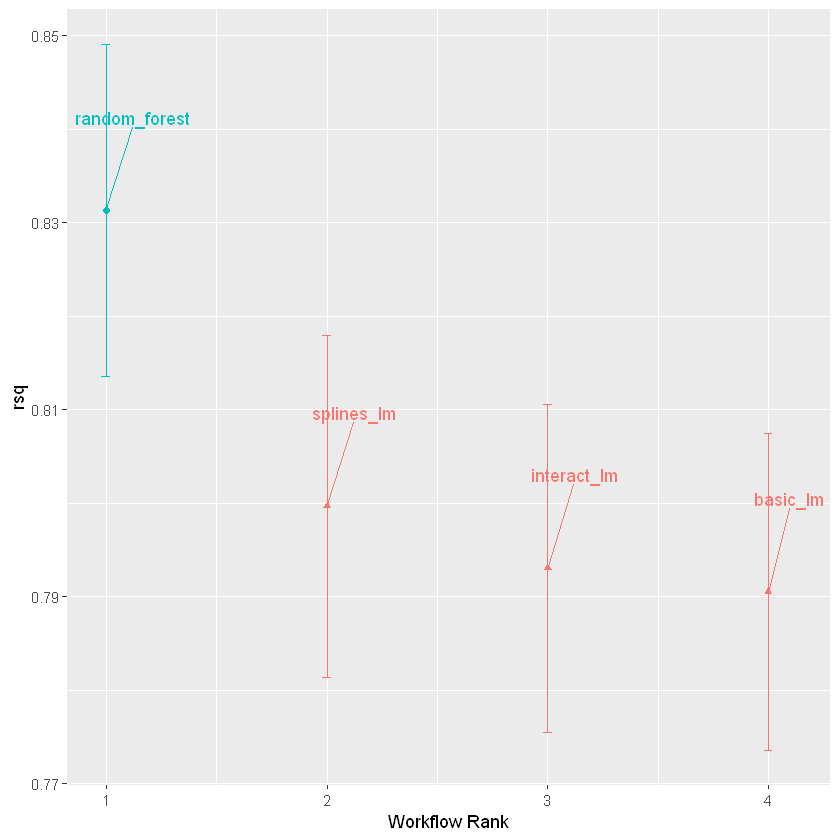

In [62]:
library(ggrepel)
autoplot(four_models, metric = "rsq") +
  geom_text_repel(aes(label = wflow_id), nudge_x = 1/8, nudge_y = 1/100) +
  theme(legend.position = "none")

In [64]:
collect_metrics(four_models) %>% 
  filter(.metric == "rsq")

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
random_forest,Preprocessor1_Model1,formula,rand_forest,rsq,standard,0.8313279,10,0.01080060
basic_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.7905545,10,0.01030256
interact_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.7930594,10,0.01064815
splines_lm,Preprocessor1_Model1,recipe,linear_reg,rsq,standard,0.7996859,10,0.01113578


# Screening Many Models

For projects with new data sets that have not yet been well understood, a data practitioner may need to screen many combinations of models and preprocessors. It is common to have little or no a priori knowledge about which method will work best with a novel data set.

> A good strategy is to spend some initial effort trying a variety of modeling approaches, determine what works best, then invest additional time tweaking/optimizing a small set of models.

A wide variety of models were evaluated with different predictor sets and preprocessing needs. How can workflow sets make such a process of large scale testing for models easier?

First, let’s define the data splitting and resampling schemes.els)

In [65]:
library(tidymodels)
tidymodels_prefer()

data(concrete, package = "modeldata")
glimpse(concrete)

Rows: 1,030
Columns: 9
$ cement               <dbl> 540.0, 540.0, 332.5, 332.5, 198.6, 266.0, 380.0, …
$ blast_furnace_slag   <dbl> 0.0, 0.0, 142.5, 142.5, 132.4, 114.0, 95.0, 95.0,…
$ fly_ash              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ water                <dbl> 162, 162, 228, 228, 192, 228, 228, 228, 228, 228,…
$ superplasticizer     <dbl> 2.5, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,…
$ coarse_aggregate     <dbl> 1040.0, 1055.0, 932.0, 932.0, 978.4, 932.0, 932.0…
$ fine_aggregate       <dbl> 676.0, 676.0, 594.0, 594.0, 825.5, 670.0, 594.0, …
$ age                  <int> 28, 28, 270, 365, 360, 90, 365, 28, 28, 28, 90, 2…
$ compressive_strength <dbl> 79.99, 61.89, 40.27, 41.05, 44.30, 47.03, 43.70, …


The compressive_strength column is the outcome. The age predictor tells us the age of the concrete sample at testing in days (concrete strengthens over time) and the rest of the predictors like cement and water are concrete components in units of kilograms per cubic meter.
> 
For some cases in this data set, the same concrete formula was tested multiple times. We’d rather not include these replicate mixtures as individual data points since they might be distributed across both the training and test set. Doing so might artificially inflate our performance estimates.

In [73]:
concrete <- concrete |>
    group_by(across(-compressive_strength)) |>
    summarize(compressive_strength = mean(compressive_strength),
             .groups = "drop")

head(concrete)

cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,compressive_strength
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
102.0,153.0,0,192.0,0,887.0,942,3,4.57
102.0,153.0,0,192.0,0,887.0,942,7,7.68
102.0,153.0,0,192.0,0,887.0,942,28,17.28
102.0,153.0,0,192.0,0,887.0,942,90,25.46
108.3,162.4,0,203.5,0,938.2,849,3,2.33
108.3,162.4,0,203.5,0,938.2,849,7,7.72


In [74]:
# Let’s split the data using the default 3:1 ratio of training-to-test and resample the training set using five repeats of 10-fold cross-validation:

set.seed(1501)
concrete_split <- initial_split(concrete, strata = compressive_strength)
concrete_train <- training(concrete_split)
concrete_test  <- testing(concrete_split)

set.seed(1502)
concrete_folds <- 
   vfold_cv(concrete_train, strata = compressive_strength, repeats = 5)

Some models (notably neural networks, KNN, and support vector machines) require predictors that have been centered and scaled, so some model workflows will require recipes with these preprocessing steps. For other models, a traditional response surface design model expansion (i.e., quadratic and two-way interactions) is a good idea. For these purposes, we create two recipes:

In [75]:
normalized_rec <- 
   recipe(compressive_strength ~ ., data = concrete_train) %>% 
   step_normalize(all_predictors()) 

poly_recipe <- 
   normalized_rec %>% 
   step_poly(all_predictors()) %>% 
   step_interact(~ all_predictors():all_predictors())

In [80]:
library(rules)
library(baguette)

# Regularized regression
linear_reg_spec <- 
   linear_reg(penalty = tune(), mixture = tune()) %>% 
   set_engine("glmnet")


# Neural Network
nnet_spec <- 
   mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>% 
   set_engine("nnet", MaxNWts = 2600) %>% 
   set_mode("regression")



mars_spec <- 
   mars(prod_degree = tune()) %>%  #<- use GCV to choose terms
   set_engine("earth") %>% 
   set_mode("regression")


# RBF SVM
svm_r_spec <- 
   svm_rbf(cost = tune(), rbf_sigma = tune()) %>% 
   set_engine("kernlab") %>% 
   set_mode("regression")

# SVM
svm_p_spec <- 
   svm_poly(cost = tune(), degree = tune()) %>% 
   set_engine("kernlab") %>% 
   set_mode("regression")


# KNN
knn_spec <- 
   nearest_neighbor(neighbors = tune(), dist_power = tune(), weight_func = tune()) %>% 
   set_engine("kknn") %>% 
   set_mode("regression")


# CART
cart_spec <- 
   decision_tree(cost_complexity = tune(), min_n = tune()) %>% 
   set_engine("rpart") %>% 
   set_mode("regression")


# Bag CART
bag_cart_spec <- 
   bag_tree() %>% 
   set_engine("rpart", times = 50L) %>% 
   set_mode("regression")


# RF model
rf_spec <- 
   rand_forest(mtry = tune(), min_n = tune(), trees = 1000) %>% 
   set_engine("ranger") %>% 
   set_mode("regression")


# XGBoost
xgb_spec <- 
   boost_tree(tree_depth = tune(), learn_rate = tune(), loss_reduction = tune(), 
              min_n = tune(), sample_size = tune(), trees = tune()) %>% 
   set_engine("xgboost") %>% 
   set_mode("regression")


# 
cubist_spec <- 
   cubist_rules(committees = tune(), neighbors = tune()) %>% 
   set_engine("Cubist")

Warning message:
"package 'baguette' was built under R version 4.3.2"


The analysis in M. Kuhn and Johnson (2013) specifies that the neural network should have up to 27 hidden units in the layer. The extract_parameter_set_dials() function extracts the parameter set, which we modify to have the correct parameter range:

In [81]:
nnet_param <- 
   nnet_spec %>% 
   extract_parameter_set_dials() %>% 
   update(hidden_units = hidden_units(c(1, 27)))

## Creating A workflow set

In [86]:
normalized <- 
   workflow_set(
      preproc = list(normalized = normalized_rec), 
      models = list(SVM_radial = svm_r_spec, SVM_poly = svm_p_spec, 
                    KNN = knn_spec, neural_network = nnet_spec)
   )
# normalized

In [90]:
normalized |>
    extract_workflow(id = "normalized_KNN")

══ Workflow ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = tune()
  dist_power = tune()

Computational engine: kknn 


The option column is a placeholder for any arguments to use when we evaluate the workflow. For example, to add the neural network parameter object:

In [91]:
normalized <- 
   normalized %>% 
   option_add(param_info = nnet_param, id = "normalized_neural_network")

In [92]:
# Other workflows

model_vars <- 
   workflow_variables(outcomes = compressive_strength, 
                      predictors = everything())

no_pre_proc <- 
   workflow_set(
      preproc = list(simple = model_vars), 
      models = list(MARS = mars_spec, CART = cart_spec, CART_bagged = bag_cart_spec,
                    RF = rf_spec, boosting = xgb_spec, Cubist = cubist_spec)
   )
no_pre_proc

wflow_id,info,option,result
<chr>,<list>,<list>,<list>
simple_MARS,"~compressive_strength, ~everything(), ~NULL, ~tune(), ~NULL, regression, TRUE, earth, TRUE, FALSE, workflow_variables, mars,",NULL,NULL
simple_CART,"~compressive_strength, ~everything(), ~tune(), ~NULL, ~tune(), regression, TRUE, rpart, TRUE, FALSE, workflow_variables, decision_tree,",NULL,NULL
simple_CART_bagged,"~compressive_strength, ~everything(), ~0, ~NULL, ~2, ~NULL, ~50L, regression, TRUE, rpart, TRUE, FALSE, workflow_variables, bag_tree,",NULL,NULL
simple_RF,"~compressive_strength, ~everything(), ~tune(), ~1000, ~tune(), regression, TRUE, ranger, TRUE, FALSE, workflow_variables, rand_forest,",NULL,NULL
simple_boosting,"~compressive_strength, ~everything(), ~NULL, ~tune(), ~tune(), ~tune(), ~tune(), ~tune(), ~tune(), ~NULL, regression, TRUE, xgboost, TRUE, FALSE, workflow_variables, boost_tree,",NULL,NULL
simple_Cubist,"~compressive_strength, ~everything(), ~tune(), ~tune(), ~NULL, regression, FALSE, Cubist, TRUE, FALSE, workflow_variables, cubist_rules,",NULL,NULL


Finally, we assemble the set that uses nonlinear terms and interactions with the appropriate models:

In [94]:
with_features <- 
   workflow_set(
      preproc = list(full_quad = poly_recipe), 
      models = list(linear_reg = linear_reg_spec, KNN = knn_spec)
   )

In [97]:
all_workflows <- 
   bind_rows(no_pre_proc, normalized, with_features) %>% 
   # Make the workflow ID's a little more simple: 
   mutate(wflow_id = gsub("(simple_)|(normalized_)", "", wflow_id))

# all_workflows

## TUNING AND EVALUATING THE MODELS

Almost all of the members of all_workflows contain tuning parameters. To evaluate their performance, we can use the standard tuning or resampling functions (e.g., tune_grid() and so on). The workflow_map() function will apply the same function to all of the workflows in the set; the default is tune_grid().

For this example, grid search is applied to each workflow using up to 25 different parameter candidates. There are a set of common options to use with each execution of tune_grid(). For example, in the following code we will use the same resampling and control objects for each workflow, along with a grid size of 25. The workflow_map() function has an additional argument called seed, which is used to ensure that each execution of tune_grid() consumes the same random numbers.

In [106]:
grid_ctrl <-
   control_grid(
      save_pred = TRUE,
      parallel_over = "everything",
      save_workflow = TRUE
   )



grid_results <-
   all_workflows %>%
   workflow_map(
      seed = 1503,
      resamples = concrete_folds,
      grid = 25,
      control = grid_ctrl
   )


# grid_results

i Creating pre-processing data to finalize unknown parameter: mtry

Warning message:
"package 'xgboost' was built under R version 4.3.2"
Warning message:
"package 'kknn' was built under R version 4.3.2"
Warning message:
"package 'glmnet' was built under R version 4.3.2"


In [117]:
collect_metrics(grid_results)

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
MARS,Preprocessor1_Model1,workflow_variables,mars,rmse,standard,6.5186023,50,0.158459881
MARS,Preprocessor1_Model1,workflow_variables,mars,rsq,standard,0.8437498,50,0.007994067
MARS,Preprocessor1_Model2,workflow_variables,mars,rmse,standard,6.2801635,50,0.089738723
MARS,Preprocessor1_Model2,workflow_variables,mars,rsq,standard,0.8553238,50,0.004521954
CART,Preprocessor1_Model01,workflow_variables,decision_tree,rmse,standard,11.5016313,50,0.138620364
CART,Preprocessor1_Model01,workflow_variables,decision_tree,rsq,standard,0.5160462,50,0.008660939
CART,Preprocessor1_Model02,workflow_variables,decision_tree,rmse,standard,7.3737907,50,0.165406832
CART,Preprocessor1_Model02,workflow_variables,decision_tree,rsq,standard,0.8066402,50,0.007766903
CART,Preprocessor1_Model03,workflow_variables,decision_tree,rmse,standard,8.2384269,50,0.139988859


In [115]:
collect_metrics(grid_results) |>
               filter(.metric == 'rsq') |>
               arrange(desc(mean)) 

wflow_id,.config,preproc,model,.metric,.estimator,mean,n,std_err
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
boosting,Preprocessor1_Model04,workflow_variables,boost_tree,rsq,standard,0.9334518,50,0.002990715
boosting,Preprocessor1_Model06,workflow_variables,boost_tree,rsq,standard,0.9319413,50,0.002997219
boosting,Preprocessor1_Model13,workflow_variables,boost_tree,rsq,standard,0.9314912,50,0.003003389
boosting,Preprocessor1_Model14,workflow_variables,boost_tree,rsq,standard,0.9286359,50,0.003268780
boosting,Preprocessor1_Model03,workflow_variables,boost_tree,rsq,standard,0.9271602,50,0.002853788
boosting,Preprocessor1_Model16,workflow_variables,boost_tree,rsq,standard,0.9267659,50,0.003002573
boosting,Preprocessor1_Model15,workflow_variables,boost_tree,rsq,standard,0.9264740,50,0.002941339
boosting,Preprocessor1_Model05,workflow_variables,boost_tree,rsq,standard,0.9244940,50,0.002858795
Cubist,Preprocessor1_Model24,workflow_variables,cubist_rules,rsq,standard,0.9190887,50,0.002993511


The option column now contains all of the options that we used in the workflow_map() call. This makes our results reproducible. In the result columns, the “tune[+]” and “rsmp[+]” notations mean that the object had no issues. A value such as “tune[x]” occurs if all of the models failed for some reason.

There are a few convenience functions for examining results such as grid_results. The rank_results() function will order the models by some performance metric. By default, it uses the first metric in the metric set (RMSE in this instance). Let’s filter() to look only at RMSE:

In [118]:
grid_results %>% 
   rank_results() %>% 
   filter(.metric == "rsq") %>% 
   select(model, .config, rmse = mean, rank)

model,.config,rmse,rank
<chr>,<chr>,<dbl>,<int>
boost_tree,Preprocessor1_Model04,0.9334518,1
boost_tree,Preprocessor1_Model06,0.9319413,2
boost_tree,Preprocessor1_Model13,0.9314912,3
boost_tree,Preprocessor1_Model14,0.9286359,4
boost_tree,Preprocessor1_Model16,0.9267659,5
boost_tree,Preprocessor1_Model03,0.9271602,6
boost_tree,Preprocessor1_Model15,0.9264740,7
boost_tree,Preprocessor1_Model05,0.9244940,8
boost_tree,Preprocessor1_Model20,0.9188046,9


Also by default, the function ranks all of the candidate sets; that’s why the same model can show up multiple times in the output. An option, called select_best, can be used to rank the models using their best tuning parameter combination.

The autoplot() method plots the rankings; it also has a select_best argument. The plot in Figure 15.1 visualizes the best results for each model and is generated with:

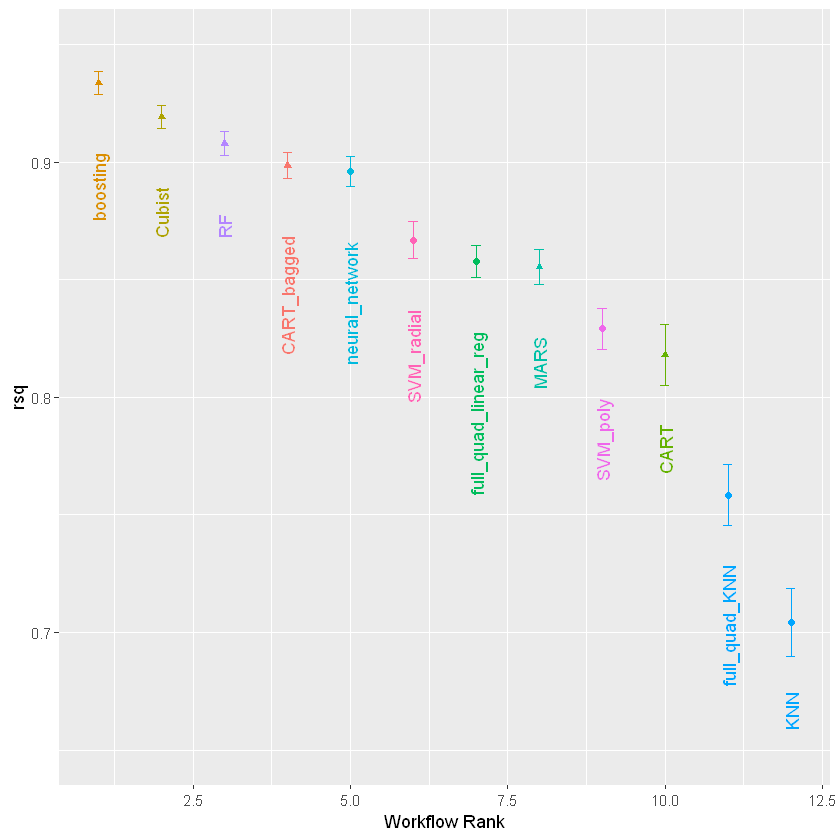

In [132]:
autoplot(
   grid_results,
   rank_metric = "rsq",  # <- how to order models
   metric = "rsq",       # <- which metric to visualize
   select_best = TRUE     # <- one point per workflow
) +
   geom_text(aes(y = mean - 0.03, label = wflow_id), angle = 90, hjust = 1) +
   lims(y = c(0.65, 0.95)) +
   theme(legend.position = "none")

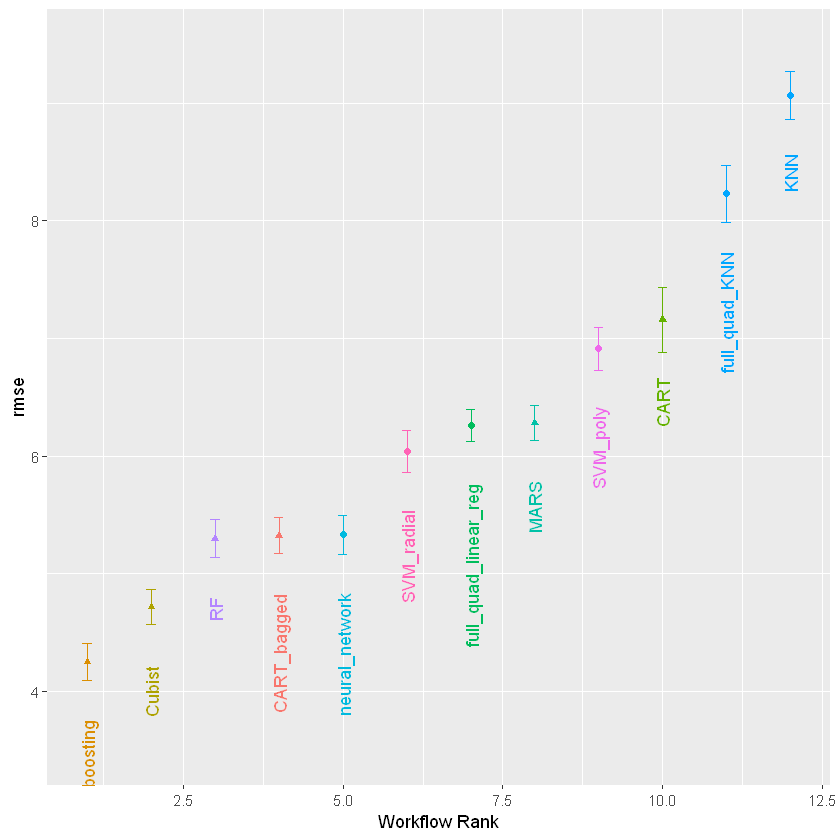

In [133]:
autoplot(
   grid_results,
   rank_metric = "rmse",  # <- how to order models
   metric = "rmse",       # <- which metric to visualize
   select_best = TRUE     # <- one point per workflow
) +
   geom_text(aes(y = mean - 1/2, label = wflow_id), angle = 90, hjust = 1) +
   lims(y = c(3.5, 9.5)) +
   theme(legend.position = "none")

# Finalizing a model


In [135]:
best_results <- 
   grid_results %>% 
   extract_workflow_set_result("boosting") %>% 
   select_best(metric = "rmse")
best_results

trees,min_n,tree_depth,learn_rate,loss_reduction,sample_size,.config
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1478,7,7,0.0900109,0.0006992648,0.8244187,Preprocessor1_Model04


In [138]:
boosting_test_results <- 
   grid_results %>% 
   extract_workflow("boosting") %>% 
   finalize_workflow(best_results) %>% 
   last_fit(split = concrete_split)

In [139]:
collect_metrics(boosting_test_results)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,3.3599983,Preprocessor1_Model1
rsq,standard,0.9553756,Preprocessor1_Model1


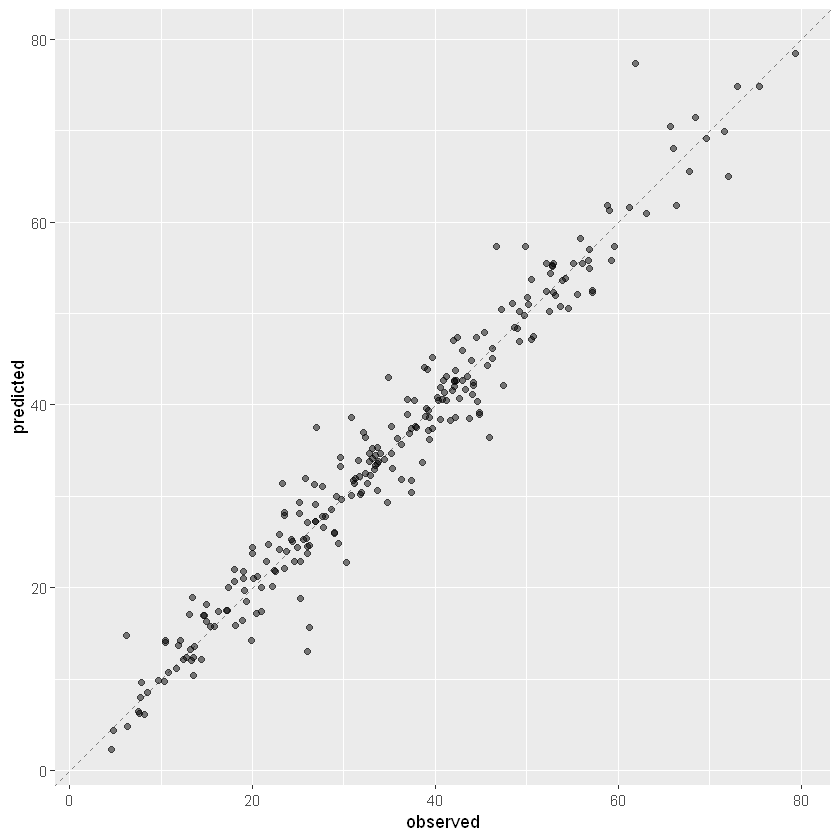

In [140]:
boosting_test_results %>% 
   collect_predictions() %>% 
   ggplot(aes(x = compressive_strength, y = .pred)) + 
   geom_abline(color = "gray50", lty = 2) + 
   geom_point(alpha = 0.5) + 
   coord_obs_pred() + 
   labs(x = "observed", y = "predicted")

# Summary Notes

> Before you start building your model, make sure your data is in a `tidy` format. You do not need to perform any imputation or feature engineering prior to the modelling.


## Step 1
- Specify the **Model**
- Set the **Engine**
- Set the **Mode** (regression or classification?)
All models are available @ [all_parsnip_models](https://www.tidymodels.org/find/parsnip)

## Step 2
- Split data into training and testing using the **rsample**
- Use k-fold cross_validation (larger datasets) or Bootstrapping (smaller datasets) on your training data and compare results of fitting models on the cross-validated trained data set


## Step 3
- Build better features using **recipes**
- Add the recipe to a model in a **workflow**
- Fit the worflow to the training data